# Matrix Sketching #

#### Authors:
v1.0 (2019 Spring) Justin Hong, Vipul Gupta, and Kannan Ramchandran

## Introduction

Sketching is an efficient matrix computation technique from randomized linear algebra with a wide range of applications like low-rank approximation, least squares, etc. During sketching, a large matrix is compressed into a smaller matrix by multiplying it by a random matrix. The smaller matrix can be then used as a proxy for the large matrix for efficient (but approximate) computation. In this lab, we will look at sketching-based multiplication of two large matrices.

## 1) Sketch Implementations ##

Gaussian-sketch and count-sketch are two popular sketching methods in the literature. You will be implementing both of them and analyzing their characteristics and performance on test data. To check your implementation, run the code blocks below the function definition to visualize the expectations and variances of each entry in $\mathbf S^T\mathbf S$ for your sketching matrix $\mathbf S$. They should parallel the results from your HW problem on matrix sketching.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

### Gaussian Sketch###
As seen in your homework, the Gaussian sketch is simply a $d\times n$ matrix where each element $S_{ij} \sim Normal(0,\frac{1}{d})$.

In [2]:
def gaussian_sketch(d, n):
    ## YOUR CODE HERE ##
    return np.random.normal(0, 1/np.sqrt(d), (d, n))

As we derived in the homework solution, the element-wise expectation and variance of $\hat{\textbf{I}} = \textbf{S}^T\textbf{S}$ are
$$
   \mathbb{E}[\hat I_{ij}] = 
\begin{cases}
    1, & \text{if} ~i=j\\
    0, & \text{otherwise}.
\end{cases}
~~~~~~~~~~
\text{Var}[\hat I_{ij}] = 
\begin{cases}
    2/d, & \text{if} ~i=j\\
    1/d, & \text{otherwise}.
\end{cases}
$$
The above expressions for Gaussian sketch can be verified by generating some nice visualizations of the variance and expectations as shown below. 

In [3]:
def visualize(fn, n=50, d=30, n_samples=50):
    # Sample generation
    sketch_matrices = [fn(d, n) for _ in range(n_samples)]
    sketch_matrices = np.stack(list(mtx.T.dot(mtx) for mtx in sketch_matrices), axis=2)
    expect_data = np.mean(sketch_matrices, axis=2)
    var_data = np.var(sketch_matrices, axis=2)
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 4))
    fig.tight_layout()
    
    im1 = ax1.imshow(expect_data, cmap='YlGn')
    cbar1 = ax1.figure.colorbar(im1, ax=ax1)
    cbar1.ax.set_ylabel("Expectation", rotation=-90, va="bottom")
    
    im2 = ax2.imshow(var_data, cmap='YlGn')
    cbar2 = ax2.figure.colorbar(im2, ax=ax2)
    cbar2.ax.set_ylabel("Variance", rotation=-90, va="bottom")
    return

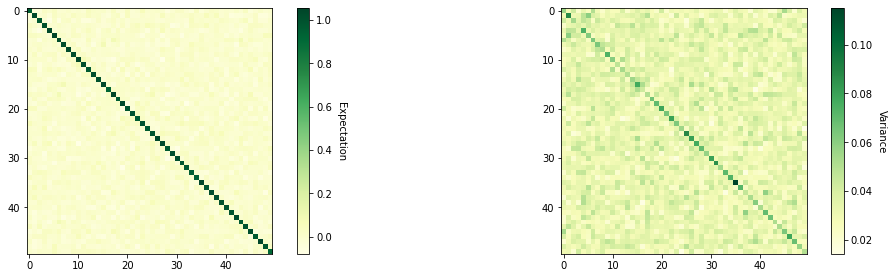

In [4]:
visualize(gaussian_sketch)

Note how the diagonal entries of the $n\times n$ matrix $\mathbf{\hat I}$ are close to one and non-diagonal entries are close to zero in expectation. Similarly, the variance of each element in $\mathbf{\hat I}$ is small (diagonal entries have more variance than non-diagonal entries as predicted by our expression for variance of $\mathbf{\hat I}$).

### Count Sketch###
The count sketch is slightly more involved.
For each column $j\in [1,n]$ of $\textbf{S}$, choose a row $i$ uniformly randomly from $[1,d]$ such that 
$$
   S_{ij}= 
\begin{cases}
    1,& \text{with probability} ~0.5\\
    -1,              & \text{with probability}~ 0.5
\end{cases}
$$
and assign $S_{kj} = 0$ for all $k\neq i$. An example of a $3\times 8$ count-sketch is 
$$ \textbf{S} = \begin{bmatrix} 
    0 & -1 & 1 & 0 & 0 & 1 & 0 & 0\\
    1 & 0 & 0 & 0 & -1 & 0 & -1 & 0\\
    0 & 0 & 0 & -1 & 0 & 0 & 0 & -1
\end{bmatrix}
$$ 

Next, we implement the function that generates a count-sketch (this we have implemented for you).

In [5]:
def count_sketch(d, n):
    sketch = np.zeros((d, n))
    """
    mappings: n-dimesional vector (j-th entry denotes which row-element is non-zero for the j-th column) 
    flips: denotes whether the non-zero element is 1 or -1
    """
    mappings = np.random.randint(0, d, size=(1, n))
    flips = np.random.choice([-1,1], size=(1, n))
    sketch[mappings, np.arange(n)] = flips
    return sketch

The element-wise expectation and variance of the matrix $\hat{\textbf{I}} = \textbf{S}^T\textbf{S}$ are (see homework solution)
$$
   \mathbb{E}[\hat I_{ij}] = 
\begin{cases}
    1, & \text{if} ~i=j\\
    0, & \text{otherwise}.
\end{cases}
~~~~~~~~~~
\text{Var}[\hat I_{ij}] = 
\begin{cases}
    0, & \text{if} ~i=j\\
    1/d, & \text{otherwise}.
\end{cases}
$$
Again, we verify the above expressions for count sketch by generating similar visualizations below. 

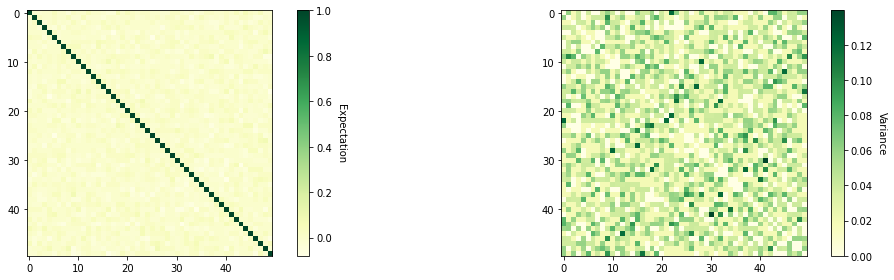

In [6]:
visualize(count_sketch)

Note how the matrix $\hat{\textbf{I}}$ is close to identity in expectation. The variance of the diagonal entries is exactly zero, while the non-diagonal variance is small.

## 2) Sketched Matrix Multiplication ##

Next, we will discuss approximate matrix multiplication using sketching. We will compute the matrix product $\mathbf A^T\mathbf A$, where $\mathbf A \in \mathcal{R}^{n\times m}$, using Gaussian and count sketches and compare it with the exact product.

As can be noted from the expression of variance of $\mathbf{\hat I} = \textbf{S}^T\textbf{S}$, the accuracy of the sketching-based computation increases as the sketch dimension $d$ increases, that is, $\mathbf{\hat I}$ closely approximates $\mathbf I$. To see how well sketching approximates the matrix product $\mathbf A^T\mathbf A$, we will use the Frobenius norm error $\parallel{}(\mathbf{SA})^T\mathbf{SA} - \mathbf{A}^T\mathbf A \parallel_F$ as a metric for distance from the actual product. More specifically, we define percentage error in sketched matrix multiplication as
$$Error (\%) = 100\times\frac{\parallel{}(\mathbf{SA})^T\mathbf{SA} - \mathbf{A}^T\mathbf A \parallel_F}{\parallel{}\mathbf{A}^T\mathbf A \parallel_F}.$$
Our definition of error is one way to capture the element-wise similarity between the two matrices.

(Note: The frobenius norm of a matrix $\mathbf{M}$ is $\|\mathbf{M}\|_F = \sqrt{\sum_{i,j} M_{ij}^2}$).

Next, we will calculate the compute times for sketched matrix multiplication and compare it with the time required for exact multiplication.

In [7]:
# Generate a random matrix A of size n x m
n = 15000
m = 1000
A = np.random.normal(50, 100, size = (n, m))

In [8]:
def calc_gauss_sketch(d, A):
    """
    Calculates Gaussian-sketch of A, that is S*A, with sketch-dimension d
    """
    ##### Write your CODE here (use the function gaussian_sketch). Should take one or two lines at most.
    return gaussian_sketch(d, n)@A

Note that Gaussian sketch can be used to find a smaller matrix that can be used as a proxy for $\mathbf A$, but it does not help in reducing computation time for matrix multiplication. Gaussian sketching $\mathbf A$ requires $O(mnd)$ time.

However, count sketch has a special sparse structure, and we can utilize it to calculate the sketch $\mathbf C = \mathbf {SA}$ in $O(mn)$ time. This is done by directly producing the sketched matrix from $A$ rather than producing $S$ explicitly. In the function "calc_count_sketch" defined below, use the following algorithm to calculate $\mathbf C = \mathbf {SA}$ directly from $\mathbf A$.
<br>
1. Set $\mathbf C$ to be an all zeros matrix in $\mathcal{R}^{d\times m}$.
2. For each row of $A$, flip the sign with probability 0.5, and then add it to a randomly picked row of $C$.

In [13]:
def calc_count_sketch(d, A):
    """
    Calculates count-sketch of A, that is S*A, with sketch-dimension d using the algorithm above
    """
    ##### Write your CODE here 
    C = np.zeros((d, m))
    for i in range(n):
        if np.random.rand() < 0.5:
            C[np.random.randint(d)] += A[i]
        else:
            C[np.random.randint(d)] -= A[i]
    return C

In [14]:
def calc_error(exact_product, sketched_product):
    """
    Calculate percentage error in Frobenius norm as defined above
    """
    return 100*np.linalg.norm(exact_product - sketched_product, ord='fro')/np.linalg.norm(exact_product, ord='fro')

In [15]:
def generate_plots(A, num_samples = 5):
    """
    This function generates time and error plots for sketched matrix multiplication
    """
    n,m = A.shape
    sketch_dims = [int(m*x/4) for x in range(5,12,1)]
    print("Sketch dimensions considered")
    print(list(sketch_dims))
    
    a = len(sketch_dims)
    g_time = np.zeros(a)
    g_error = np.zeros(a)
    c_time = np.zeros(a)
    c_error = np.zeros(a)
    iter = 0
       
    ## Calculating exact product
    t1 = time.time()
    exact_product = (A.T).dot(A)
    t_exact = time.time() - t1
    
    for d in sketch_dims:
        for _ in range(num_samples):
            ## Gaussian sketch
            t2 = time.time()
            g_sketch = calc_gauss_sketch(d, A)
            g_product = g_sketch.T.dot(g_sketch)
            g_time[iter] += time.time() - t2
            g_error[iter] += calc_error(exact_product, g_product)

            ## Count sketch
            t3 = time.time()
            c_sketch = calc_count_sketch(d, A)
            c_product = c_sketch.T.dot(c_sketch)
            c_time[iter] += time.time() - t3
            c_error[iter] += calc_error(exact_product, c_product)
        iter += 1 
    
    ## Averaging error over all sample points
    g_time = g_time/num_samples
    g_error = g_error/num_samples
    c_time = c_time/num_samples
    c_error = c_error/num_samples
    
    fig, ax = plt.subplots(1,1,figsize=(12, 4))
    ax.plot(sketch_dims, g_error, label="Gaussian Sketch")
    ax.plot(sketch_dims, c_error, label="Count Sketch")
    ax.legend(loc="best")
    ax.set_xlabel("Sketch dimension (d)")
    ax.set_ylabel("Percentage Error")
    ax.set_ylim(bottom=0)
    ax.grid(True)
    ax.set_title("Error for Count and Gaussian sketches")
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
    ax1.plot(sketch_dims, g_time, label="Gaussian Sketch")
    ax1.plot(sketch_dims, t_exact*np.ones(len(sketch_dims)), label="Exact multiplication")
    ax1.legend(loc="best")
    ax1.set_xlabel("Sketch dimension (d)")
    ax1.set_ylabel("Time to compute product (seconds)")
    ax1.set_ylim(bottom=0)
    ax1.grid(True)   
    ax1.set_title("Compute time for Gaussian-sketched Multiply")
    
    ax2.plot(sketch_dims, c_time, label="Count Sketch")
    ax2.plot(sketch_dims, t_exact*np.ones(len(sketch_dims)), label="Exact multiplication")
    ax2.legend(loc="best")
    ax2.set_xlabel("Sketch dimension (d)")
    ax2.set_ylabel("Time to compute product (seconds)")
    ax2.set_ylim(bottom=0, top=ax2.get_ylim()[1]*1.15)
    ax2.grid(True)   
    ax2.set_title("Compute time for Count-sketched Multiply")
    
    plt.show()

Sketch dimensions considered
[1250, 1500, 1750, 2000, 2250, 2500, 2750]


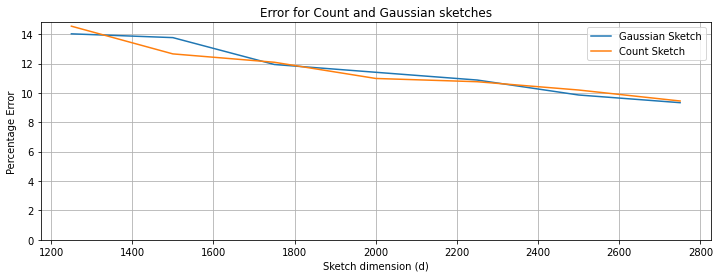

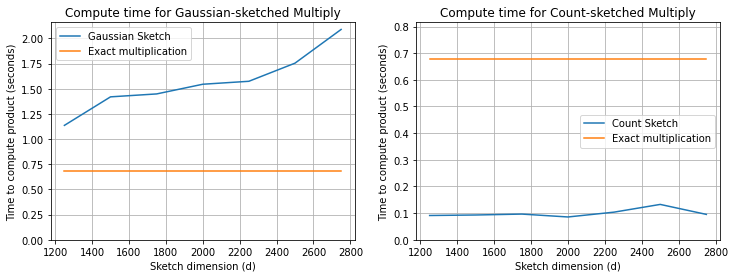

In [16]:
### This might take a few minutes to run, reduce n_samples to reduce running time (especially while debugging)
generate_plots(A)

Voila! We have improved the compute time for large matrix multiplication using count-sketch by taking advantage of the sketch characteristics. For $\mathbf A \in \mathcal{R}^{n\times m}, \mathbf S \in \mathcal{R}^{d\times n}$ and $n \gg d > m$, determine the time complexity for sketching-based multiplication for both gaussian and count sketches and compare it with the complexity for the exact multiplication $O(m^2n)$. See if it matches the figures generated above. Note that the time complexities given earlier in the lab were only for finding the sketching matrix $\mathbf A$ and not the time complexity for the whole multiplication.

##### YOUR ANSWER HERE ####